# CNN을 활용한 이미지 인식
* CNN: Convolutional Neural Network(합성곱 신경망)
* 합성곱 처리: 위치의 이동과 관련이 없는 특징량을 검출 가능
* 풀링 처리: 물체의 크기와 관련이 없는 보편적인 특징량을 추출하는 것에 특화

In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary
from torchviz import make_dot
from torch import nn

In [2]:
#CNN 모델 전반 부분, 레이어 함수 정의
conv1 = nn.Conv2d(3, 32, 3)# nn.Conv2d(입력채널 수, 출력 채널 수, 커널사이즈)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2)) #nn.MaxPood2d((가로, 세로)), (가로, 세로): 작은 사각형의 화소 수

In [3]:
print(conv1)
print(conv1.weight.shape)
print(conv1.bias.shape)

print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


#### 합성곱 처리와 풀링 처리 시뮬레이션

In [4]:
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [5]:
#CNN 전반부 처리 시뮬레이션

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [6]:
# 각 변수의 shape 확인
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)
#torch.Size([데이터 건수, 채널수, 화소수(가로) , 화소수(세로)])
"""
화소수: 32-> 30 -> 28
가중치 행렬(커널)이 3x3이라는 점과, 합성곱 처리 행렬의 사이즈 -1만큼 
출력 데이터의 화소수가 줄어든다는 것에 상응
풀링처리: 가로세로 사이즈 절반 됨
relu: 사이즈 변화 X
"""

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


'\n화소수: 32-> 30 -> 28\n가중치 행렬(커널)이 3x3이라는 점과, 합성곱 처리 행렬의 사이즈 -1만큼 \n출력 데이터의 화소수가 줄어든다는 것에 상응\n풀링처리: 가로세로 사이즈 절반 됨\nrelu: 사이즈 변화 X\n'

In [7]:
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [8]:
outputs = features(inputs)

print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [9]:
flatten = nn.Flatten() #.view와 같이 1계 텐서로 바꿔줌

outputs2 = flatten(outputs)

print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


#### 공통 함수 사용하기

In [40]:
#eval_loss(손실 계산)
def eval_loss(loader, net, criterion):
    #데이터 로더에서 처음 한 개 세트를 가져옴
    for images, labels in loader:
        break

    inputs = images
    labels = labels

    #예측 계산
    outputs = net(inputs)

    #손실 계산
    loss = criterion(outputs, labels)

    return loss

In [44]:
#fit(학습):인수 --> net, optimizer, criterion, num_epoch, train_loader, test_loader, device, history
#이 방법에서는, net 변수도 초기화시키지 않고, 이전 학습에 사용한 인스턴스를 그대로 인수로 넘겨줘야함
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [12]:
#evaluate_history(학습 로그): 손실, 정확도 그래프
def evaluate_history(history):
    print(f'초기 상태 손실: {history[0, 1]:.5f}   초기 상태 정확도:{history[0, 2]:.5f}')
    print(f'최종 상태 손실: {history[-1, 1]:.5f}   최종 상태 정확도:{history[-1, 2]}')

    num_epochs = len(history)
    unit = num_epochs / 10

    plt.figure(figsize=(9,8))
    plt.plot(history[:, 0], history[:, 1], c='b', label = 'Train_Loss')
    plt.plot(history[:, 0], history[:, 3], c='k', label = 'Val_Loss')
    plt.xticks(np.arange(0, num_epochs, unit))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()


    plt.figure(figsize=(9, 8))    
    plt.plot(history[:, 0], history[:, 2], c='b', label = 'Train_Acc')
    plt.plot(history[:, 0], history[:, 4], c='k', label = 'Val_Acc')
    plt.xticks(np.arange(0, num_epochs, unit))
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.grid()
    plt.legend()
    plt.show()

In [13]:
#show_images_labels(예측 결과 표시): 긁어옴 ㅋㅋ
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net):#, device

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)

    if net is not None:
      # 디바이스 할당
    #   inputs = images.to(device)
    #   labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [14]:
#난수고정(그냥 공통함수로 정의해버림)
def torch_seed(seed=123):
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms = True

### 데이터 준비

In [15]:
#Transforms 정의
#전처리에 대해 1계 텐서버전과 3계 텐서 버전 두 개를 만들 것이므로 총 두가지 패턴을 준비

#transforms 1계 텐서화
transforms1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x : x.view(-1)),
])

#transforms2 정규화만 실시

#검증 데이터용 : 정규화만 실시
transforms2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [16]:
#URL에러 방지(예예)
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [17]:
#데이터셋 정의

data_root = './data'

#훈련 데이터셋(1계 텐서 버전)
train_set1 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transforms1
)

#검증 데이터셋(1계 텐서 버전)
test_set1 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transforms1
)

#훈련 데이터셋(3계 텐서 버전)
train_set2 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transforms2
)

test_set2 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transforms2
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [28]:
#데이터셋 확인
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [19]:
from torch.utils.data import DataLoader

In [20]:
#데이터로더 정의

#미니배치사이즈 정의
batch_size = 100

#훈련용 데이터 로더
#훈련용 --> 셔플 True
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

#검증 데이터 로더
#검증용 --> 셔플 False
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=False)

#훈련용 데이터 로더
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

#검증 데이터 로더
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

In [30]:
for image1, label1 in train_loader1:
    break

for image2, label2 in train_loader2:
    break

print(image1.shape)
print(image2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


In [34]:
print(image1.shape[1])

3072


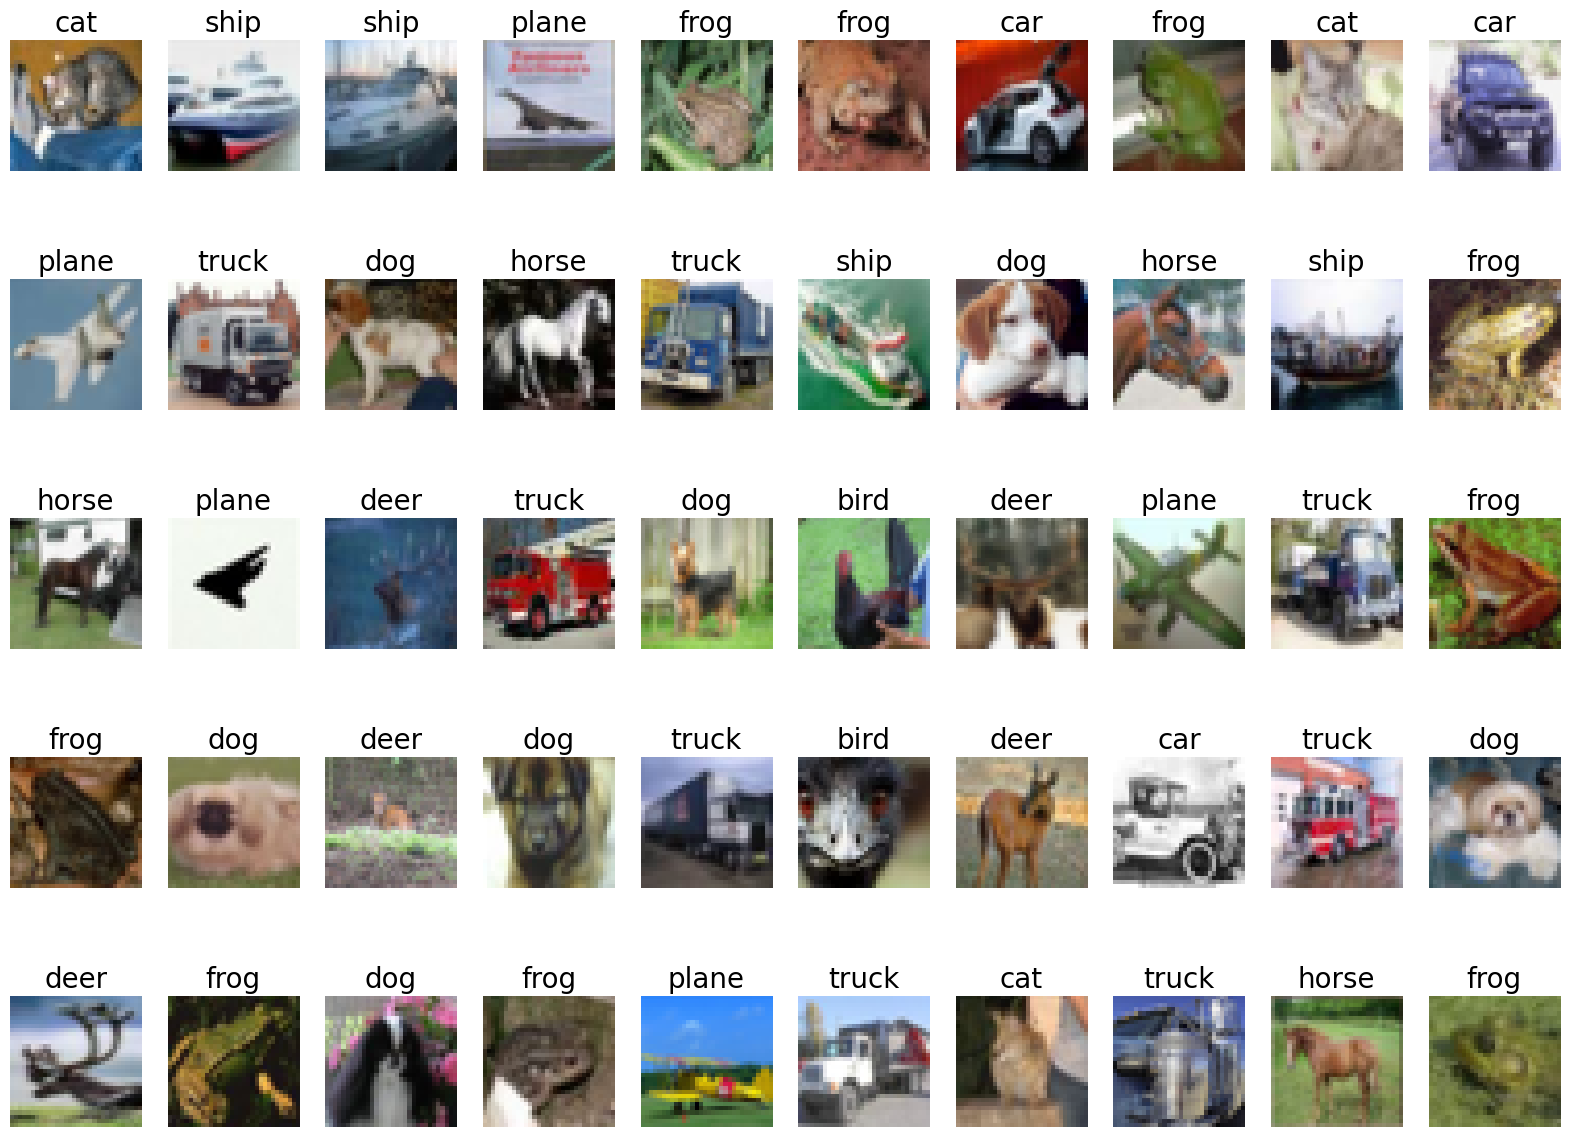

In [22]:
#검증 데이터를 이미지로 표시
#정답 라벨 정의
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

#검증 데이터의 처음 50개 출력
show_images_labels(test_loader2, classes, None)

#### 모델 정의(전결합형)

In [23]:
#모델 정의
#3072 입력, 10출력 1은닉층
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_hidden)

        self.l2 = nn.Linear(n_hidden, n_output)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)

        return x3

In [35]:
n_input = image1.shape[1]

n_output = len(set(list(label1.data.numpy())))

n_hidden = 128

print(f'입력층:{n_input} 출력층:{n_output} 은닉층:{n_hidden}')

입력층:3072 출력층:10 은닉층:128


In [39]:
summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

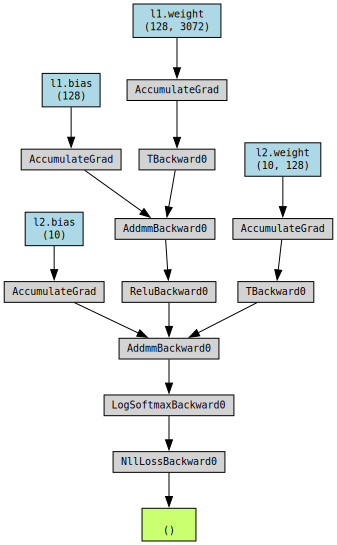

In [43]:
loss = eval_loss(test_loader1, net, criterion)
g = make_dot(loss , params=dict(net.named_parameters()))
display(g)

#### 결과(전결합형)

In [45]:
#초기화
torch_seed()

net = Net(n_input, n_output, n_hidden)

criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr = lr)

num_epoch = 50

history = np.zeros((0, 5))

history = fit(net, optimizer, criterion, num_epoch, train_loader1, test_loader1, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32214 val_loss: 0.01794, val_acc: 0.37730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39598 val_loss: 0.01684, val_acc: 0.41790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42406 val_loss: 0.01622, val_acc: 0.43830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44244 val_loss: 0.01583, val_acc: 0.45090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45554 val_loss: 0.01553, val_acc: 0.46130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46788 val_loss: 0.01530, val_acc: 0.46870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47668 val_loss: 0.01512, val_acc: 0.47340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48650 val_loss: 0.01493, val_acc: 0.47810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49592 val_loss: 0.01480, val_acc: 0.48750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50408 val_loss: 0.01463, val_acc: 0.48870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51128 val_loss: 0.01450, val_acc: 0.49500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01395 acc: 0.51986 val_loss: 0.01437, val_acc: 0.50220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52682 val_loss: 0.01425, val_acc: 0.50490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53470 val_loss: 0.01423, val_acc: 0.50570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01341 acc: 0.53950 val_loss: 0.01408, val_acc: 0.51320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54574 val_loss: 0.01402, val_acc: 0.51080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01308 acc: 0.55122 val_loss: 0.01391, val_acc: 0.51510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01294 acc: 0.55668 val_loss: 0.01388, val_acc: 0.51470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01279 acc: 0.56204 val_loss: 0.01379, val_acc: 0.52080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56592 val_loss: 0.01381, val_acc: 0.51710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01252 acc: 0.57096 val_loss: 0.01372, val_acc: 0.51820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01238 acc: 0.57656 val_loss: 0.01368, val_acc: 0.52550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58108 val_loss: 0.01363, val_acc: 0.52570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01214 acc: 0.58442 val_loss: 0.01355, val_acc: 0.52630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01201 acc: 0.59136 val_loss: 0.01353, val_acc: 0.52780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01190 acc: 0.59434 val_loss: 0.01351, val_acc: 0.52670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01178 acc: 0.59848 val_loss: 0.01350, val_acc: 0.52660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01167 acc: 0.60194 val_loss: 0.01344, val_acc: 0.53020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60522 val_loss: 0.01343, val_acc: 0.52880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01146 acc: 0.60940 val_loss: 0.01346, val_acc: 0.53080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61450 val_loss: 0.01341, val_acc: 0.52980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01125 acc: 0.61814 val_loss: 0.01338, val_acc: 0.52980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01115 acc: 0.62128 val_loss: 0.01339, val_acc: 0.53260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62494 val_loss: 0.01342, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01096 acc: 0.62870 val_loss: 0.01342, val_acc: 0.52560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63200 val_loss: 0.01335, val_acc: 0.53150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.01077 acc: 0.63518 val_loss: 0.01339, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.01068 acc: 0.63850 val_loss: 0.01336, val_acc: 0.53100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01060 acc: 0.64188 val_loss: 0.01342, val_acc: 0.52990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01051 acc: 0.64444 val_loss: 0.01349, val_acc: 0.52330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01041 acc: 0.64978 val_loss: 0.01341, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65126 val_loss: 0.01347, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65350 val_loss: 0.01346, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01017 acc: 0.65612 val_loss: 0.01346, val_acc: 0.53060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.01007 acc: 0.65942 val_loss: 0.01345, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.01001 acc: 0.66096 val_loss: 0.01344, val_acc: 0.52890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66458 val_loss: 0.01348, val_acc: 0.52650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00985 acc: 0.66796 val_loss: 0.01350, val_acc: 0.53050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67202 val_loss: 0.01363, val_acc: 0.52160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00971 acc: 0.67264 val_loss: 0.01353, val_acc: 0.53100


초기 상태 손실: 0.01950   초기 상태 정확도:0.32214
최종 상태 손실: 0.00971   최종 상태 정확도:0.67264


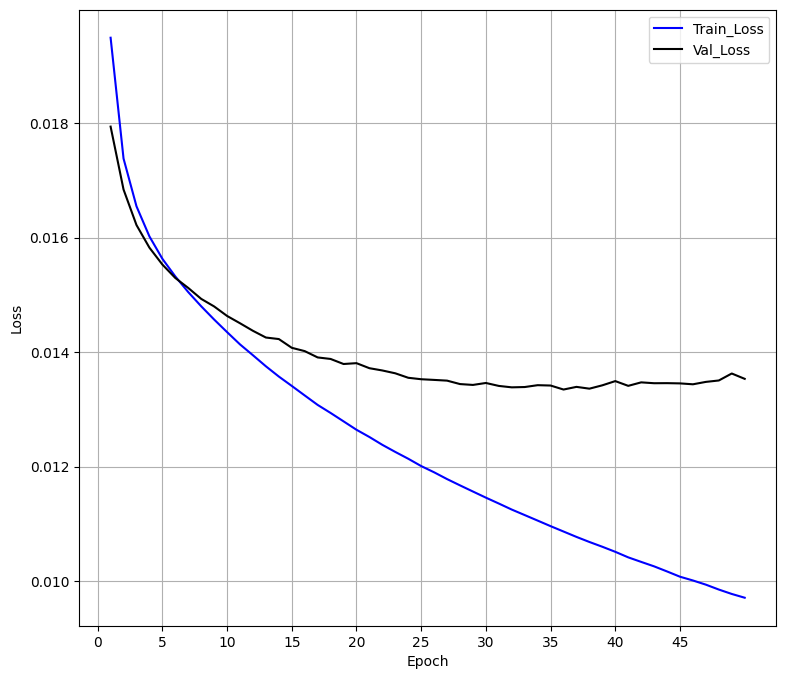

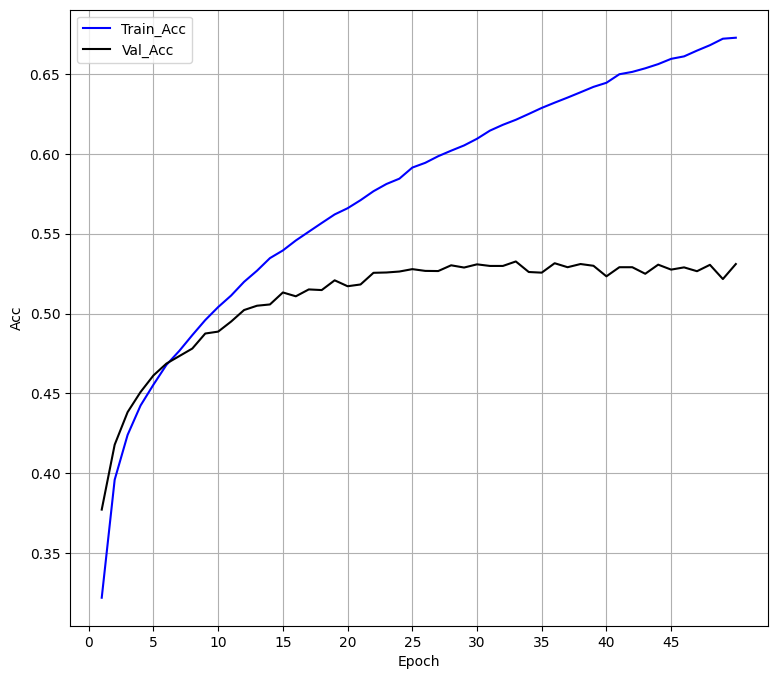

In [46]:
evaluate_history(history)

#### 모델 정의(CNN)

In [51]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(6272, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)

        return x3

In [52]:
net = CNN(n_output, n_hidden)

criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

In [53]:
print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [54]:
summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

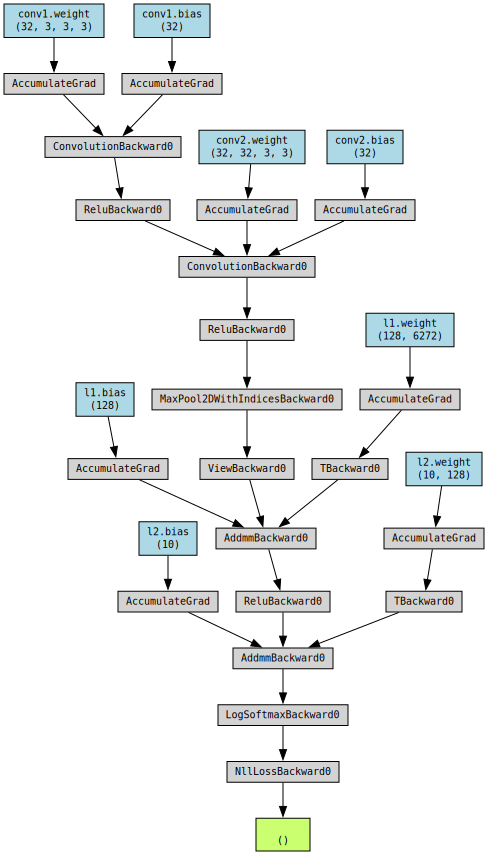

In [55]:
loss = eval_loss(test_loader2, net, criterion)

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

#### 결과(CNN)

In [56]:
torch_seed()

lr = 0.01

net = CNN(n_output, n_hidden)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=lr)

history2 = np.zeros((0, 5))

num_epoch = 50

In [57]:
#학습
history2 = fit(net, optimizer, criterion, num_epoch, train_loader2, test_loader2, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02082 acc: 0.26096 val_loss: 0.01866, val_acc: 0.34700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37316 val_loss: 0.01677, val_acc: 0.40960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43072 val_loss: 0.01530, val_acc: 0.46010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47364 val_loss: 0.01449, val_acc: 0.48820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.50042 val_loss: 0.01369, val_acc: 0.51320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52084 val_loss: 0.01332, val_acc: 0.52550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01303 acc: 0.53768 val_loss: 0.01292, val_acc: 0.54010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01252 acc: 0.55422 val_loss: 0.01252, val_acc: 0.55540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01205 acc: 0.57364 val_loss: 0.01235, val_acc: 0.56210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59086 val_loss: 0.01181, val_acc: 0.58140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01116 acc: 0.60844 val_loss: 0.01165, val_acc: 0.58850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01078 acc: 0.62276 val_loss: 0.01172, val_acc: 0.58340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01035 acc: 0.63682 val_loss: 0.01113, val_acc: 0.60480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00998 acc: 0.64986 val_loss: 0.01089, val_acc: 0.61110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00959 acc: 0.66542 val_loss: 0.01111, val_acc: 0.60590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00922 acc: 0.67668 val_loss: 0.01054, val_acc: 0.63200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00882 acc: 0.69200 val_loss: 0.01069, val_acc: 0.62070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00847 acc: 0.70394 val_loss: 0.01012, val_acc: 0.64960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00809 acc: 0.71916 val_loss: 0.01017, val_acc: 0.64440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00774 acc: 0.73124 val_loss: 0.01044, val_acc: 0.63600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00739 acc: 0.74234 val_loss: 0.01005, val_acc: 0.65310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00702 acc: 0.75724 val_loss: 0.01011, val_acc: 0.65390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00674 acc: 0.76766 val_loss: 0.00995, val_acc: 0.65940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00637 acc: 0.78068 val_loss: 0.01008, val_acc: 0.65950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00604 acc: 0.79294 val_loss: 0.00997, val_acc: 0.66570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00569 acc: 0.80512 val_loss: 0.01053, val_acc: 0.64680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00540 acc: 0.81518 val_loss: 0.01042, val_acc: 0.66250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00507 acc: 0.82794 val_loss: 0.01107, val_acc: 0.64490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00474 acc: 0.83962 val_loss: 0.01047, val_acc: 0.66830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00441 acc: 0.85280 val_loss: 0.01104, val_acc: 0.65780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00409 acc: 0.86246 val_loss: 0.01105, val_acc: 0.66430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00379 acc: 0.87350 val_loss: 0.01158, val_acc: 0.65370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00352 acc: 0.88310 val_loss: 0.01131, val_acc: 0.66260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00323 acc: 0.89442 val_loss: 0.01224, val_acc: 0.65090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00294 acc: 0.90512 val_loss: 0.01327, val_acc: 0.64280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00272 acc: 0.91168 val_loss: 0.01283, val_acc: 0.64970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00237 acc: 0.92670 val_loss: 0.01281, val_acc: 0.66390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00215 acc: 0.93366 val_loss: 0.01318, val_acc: 0.66180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00193 acc: 0.94224 val_loss: 0.01370, val_acc: 0.65850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00170 acc: 0.95118 val_loss: 0.01440, val_acc: 0.65580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00144 acc: 0.96068 val_loss: 0.01563, val_acc: 0.64930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00128 acc: 0.96588 val_loss: 0.01547, val_acc: 0.65110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00118 acc: 0.97168 val_loss: 0.01524, val_acc: 0.65570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00095 acc: 0.97846 val_loss: 0.01607, val_acc: 0.66080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00078 acc: 0.98474 val_loss: 0.01659, val_acc: 0.65870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00067 acc: 0.98804 val_loss: 0.01685, val_acc: 0.65710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00046 acc: 0.99460 val_loss: 0.01734, val_acc: 0.66170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00035 acc: 0.99662 val_loss: 0.01784, val_acc: 0.65920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00028 acc: 0.99798 val_loss: 0.01864, val_acc: 0.66360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00024 acc: 0.99840 val_loss: 0.01886, val_acc: 0.66110


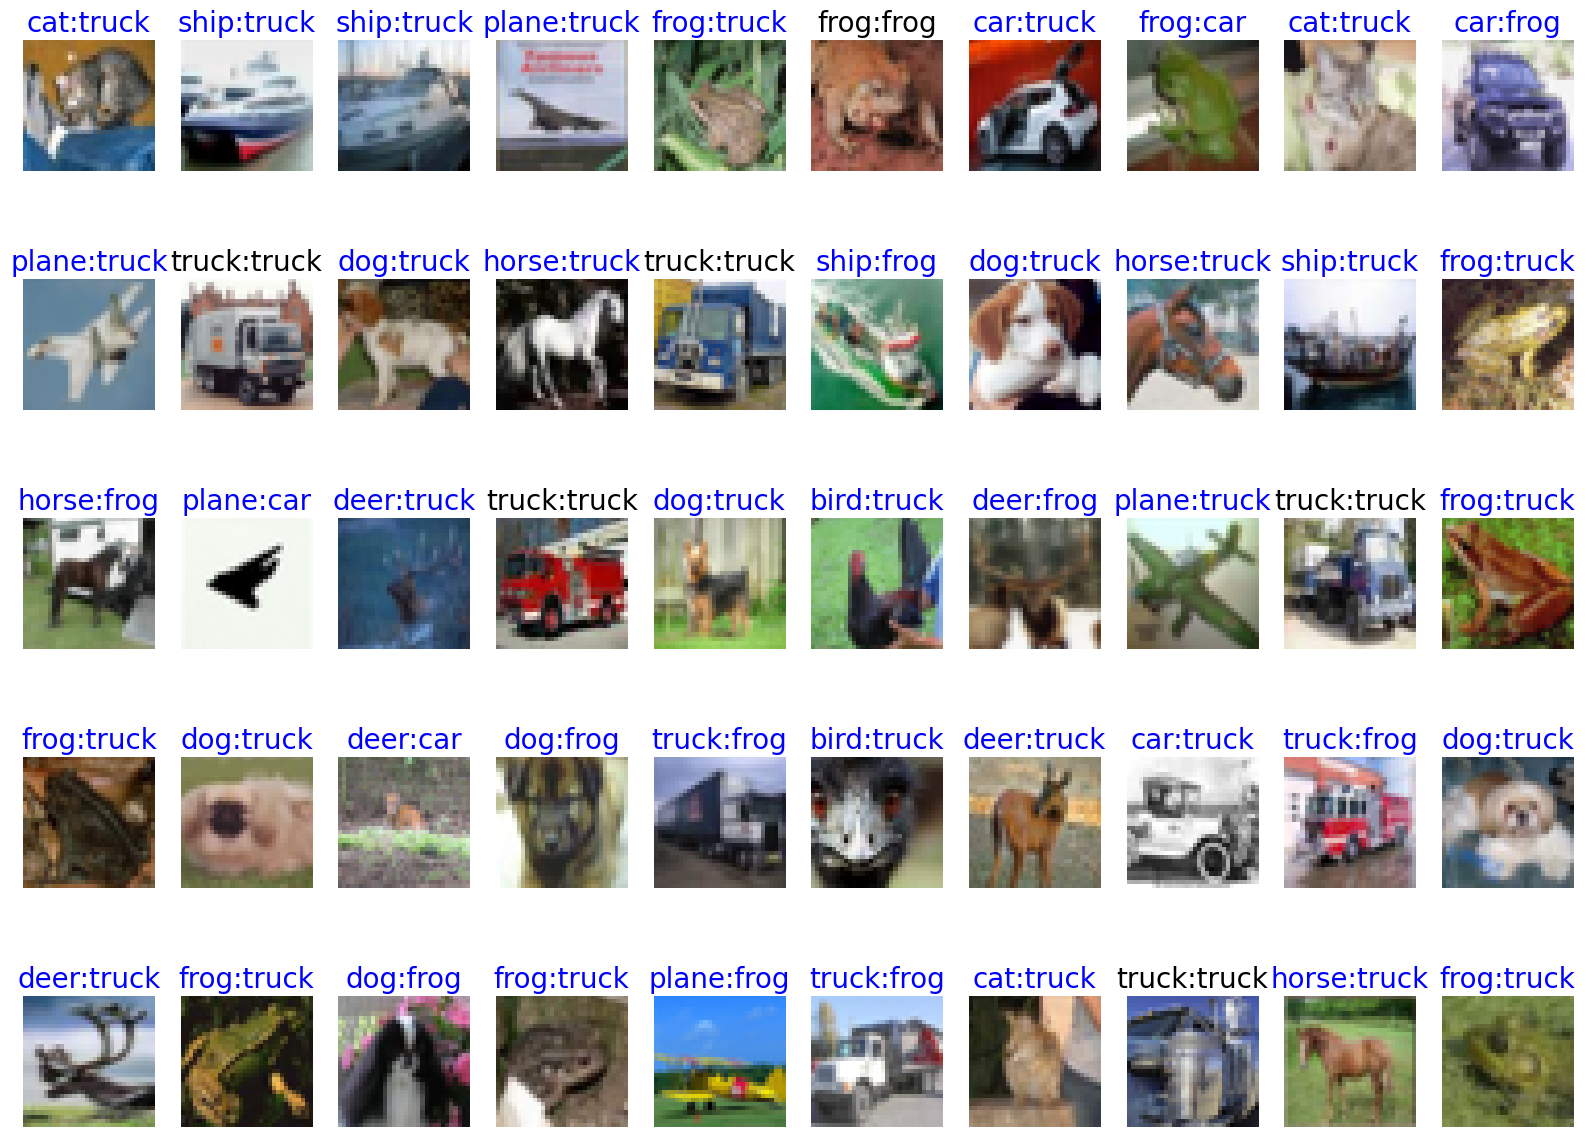

In [60]:
show_images_labels(test_loader2, classes, net)

초기 상태 손실: 0.02082   초기 상태 정확도:0.26096
최종 상태 손실: 0.00024   최종 상태 정확도:0.9984


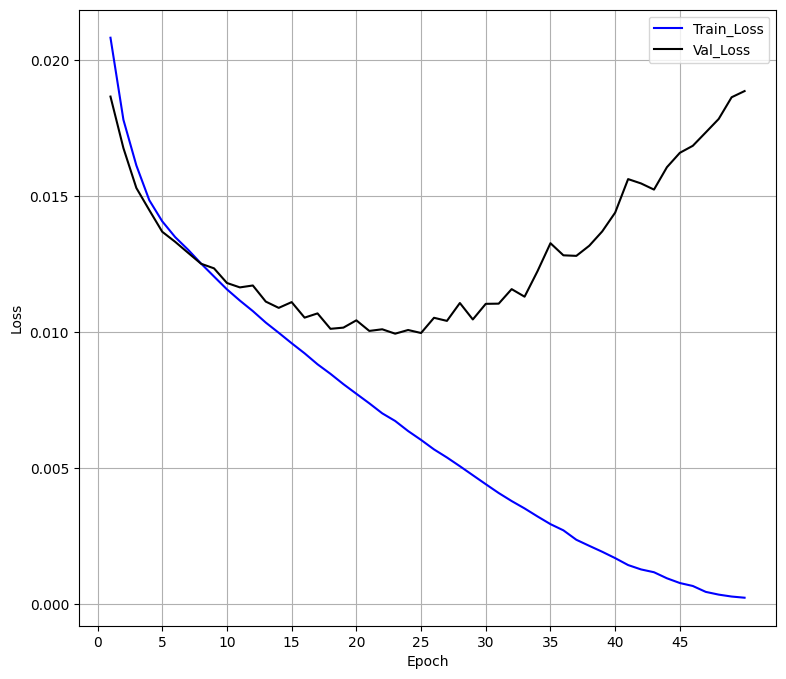

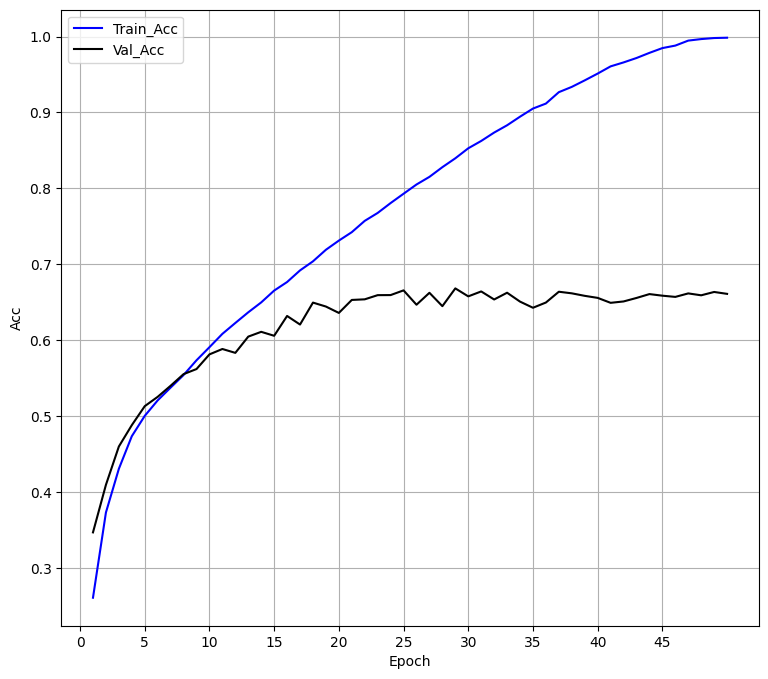

In [59]:
evaluate_history(history2)